In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pymongo
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


In [2]:
# Gaussian Process Visualization

In [3]:
class GP:
    def __init__(self, num_x_samples):
        self.observations = {"x": list(), "y": list()}
        self.num_x_samples = num_x_samples
        self.x_samples = np.arange(0, 10.0, 10.0 / self.num_x_samples).reshape(-1, 1)
        
        # prior
        self.mu = np.zeros_like(self.x_samples)
        self.cov = self.kernel(self.x_samples, self.x_samples)
        
    def update(self, observations):
        self.update_observation(observations)
        
        x = np.array(self.observations["x"]).reshape(-1, 1)
        y = np.array(self.observations["y"]).reshape(-1, 1)
        
        K11 = self.cov  # (N,N)
        K22 = self.kernel(x, x) # (k,k)
        K12 = self.kernel(self.x_samples, x)  # (N,k)
        K21 = self.kernel(x, self.x_samples)  # (k,N)
        K22_inv = np.linalg.inv(K22 + 1e-8 * np.eye(len(x)))  # (k,k)
        
        self.mu = K12.dot(K22_inv).dot(y)
        self.cov = self.kernel(self.x_samples, self.x_samples) - K12.dot(K22_inv).dot(K21)
        
    def visualize(self, num_gp_samples=3):
        gp_samples = np.random.multivariate_normal(
            mean=self.mu.ravel(), 
            cov=self.cov, 
            size=num_gp_samples)
        x_sample = self.x_samples.ravel()
        mu = self.mu.ravel()
        uncertainty = 1.96 * np.sqrt(np.diag(self.cov))

        plt.figure()
        plt.fill_between(x_sample, mu + uncertainty, mu - uncertainty, alpha=0.1)
        plt.plot(x_sample, mu, label='Mean')
        for i, gp_sample in enumerate(gp_samples):
            plt.plot(x_sample, gp_sample, lw=1, ls='--', label=f'Sample {i+1}')
            
        plt.plot(self.observations["x"], self.observations["y"], 'rx')
        plt.legend()
        plt.grid(True)

    def update_observation(self, observations):
        for x, y in zip(observations["x"], observations["y"]):
            if x not in self.observations["x"]:
                self.observations["x"].append(x)
                self.observations["y"].append(y)
                
    @staticmethod
    def kernel(x1, x2, l=0.5, sigma_f=0.2):
        dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        return sigma_f ** 2 * np.exp(-0.5 / l ** 2 * dist_matrix)

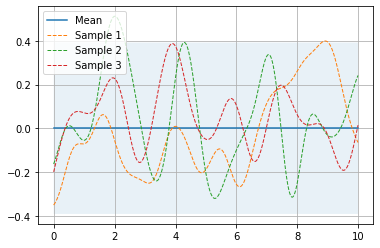

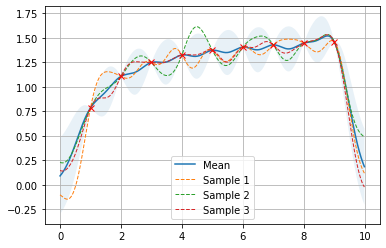

In [4]:
def y(x):
    x = np.asarray(x)
    return np.arctan(x).tolist() 

gp = GP(num_x_samples=1000)
gp.visualize()

# for _ in range(5):
#     obs_x = np.random.uniform(0, 10, size=2).tolist()
#     gp.update({"x": obs_x, "y": y(obs_x)})
#     gp.visualize()

obs_x = np.array([1, 2, 3, 4,5, 6, 7, 8, 9])
gp.update({"x": obs_x, "y": y(obs_x)})
gp.visualize()

obs1_x = np.array([1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9])
obs0_x = [i-1 for i in obs1_x]

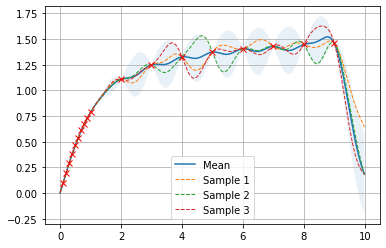

In [5]:
gp.update({"x": obs0_x, "y": y(obs0_x)})
gp.visualize()

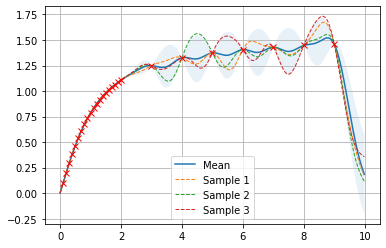

In [6]:
gp.update({"x": obs1_x, "y": y(obs1_x)})
gp.visualize()

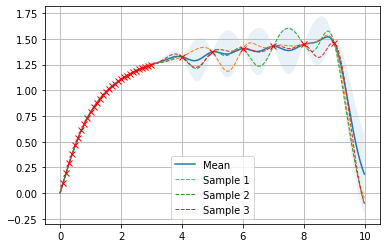

In [7]:
obs2_x = [i+1 for i in obs1_x]
gp.update({"x": obs2_x, "y": y(obs2_x)})
gp.visualize()

In [8]:
def gaussian_kernel(x1, x2, l=1.0, sigma_f=1.0):
    """Easy to understand but inefficient."""
    m, n = x1.shape[0], x2.shape[0]
    dist_matrix = np.zeros((m, n), dtype=float)
    for i in range(m):
        for j in range(n):
            dist_matrix[i][j] = np.sum((x1[i] - x2[j]) ** 2)
    return sigma_f ** 2 * np.exp(- 0.5 / l ** 2 * dist_matrix)

def gaussian_kernel_vectorization(x1, x2, l=1.0, sigma_f=1.0):
    """More efficient approach."""
    dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return sigma_f ** 2 * np.exp(-0.5 / l ** 2 * dist_matrix)

x = np.array([700, 800, 1029]).reshape(-1, 1)
print(gaussian_kernel(x,x,l=500,sigma_f = 10))
print(gaussian_kernel_vectorization(x, x, l=500, sigma_f=10))

[[100.          98.01986733  80.5347031 ]
 [ 98.01986733 100.          90.04307671]
 [ 80.5347031   90.04307671 100.        ]]
[[100.          98.01986733  80.5347031 ]
 [ 98.01986733 100.          90.04307671]
 [ 80.5347031   90.04307671 100.        ]]
